In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

# read in the data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# OPTIONAL: Test script for bugs by taking a small sample
sample_size = 1000
x_train, x_test, y_train, y_test = x_train[0:sample_size], x_test[0:sample_size], y_train[0:sample_size], y_test[0:sample_size]

print("x_train.shape:", x_train.shape)

k = len(np.unique(y_train))
print(f"number of classes: {k}")

x_train.shape: (1000, 32, 32, 3)
number of classes: 10


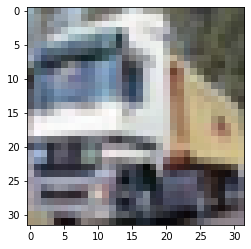

In [2]:
plt.imshow(x_train[1])

In [3]:
x_train[0].shape

(32, 32, 3)

In [4]:
#******************************************
#   Model (fit without data augmentation)
#******************************************
i = Input(shape=x_train[0].shape)
# double the num of feature maps with each conv layer:
# do NOT use strided conv bc normal conv+maxpool works better here. Ref: VGG network (multiple conv before pooling)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
## conv group 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i) # need padding='same' to avoid shrinking image after each conv
x = BatchNormalization()(x) # BatchNormalization acts as a regularizer since mu and sigma change w/ each batch
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x) # Dropout didn't help with this dataset, so leave out
## conv group 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x) # Dropout didn't help with this dataset, so leave out
## conv group 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x) # Dropout didn't help with this dataset, so leave out
## Dense group
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

Epoch 1/2
32/32 [==============================] - 27s 846ms/step - loss: 3.6084 - accuracy: 0.2430 - val_loss: 2.5819 - val_accuracy: 0.0930
Epoch 2/2
32/32 [==============================] - 26s 823ms/step - loss: 1.6865 - accuracy: 0.4310 - val_loss: 3.5674 - val_accuracy: 0.0900


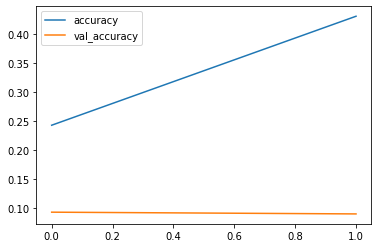

In [5]:
# Compile and fit
# Note: GPU will help a lot here
metrics_list = ['accuracy']
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=metrics_list)
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=2)
    
df_history = pd.DataFrame(history.history)
for metric in metrics_list:
    df_history[[metric, f'val_{metric}']].plot()


500/500 [==============================] - 84s 169ms/step - loss: 2.8630 - accuracy: 0.1680 - val_loss: 2.1738 - val_accuracy: 0.2370


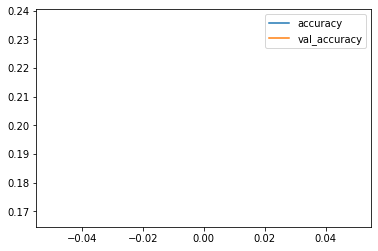

In [6]:
#******************************************
#   Model (fit with data augmentation)
#******************************************
# Note: if you run this AFTER calling the previous model.fit(), it will CONTINUE training where it left off.
# Usually that's what you want, but for experimentation we can re-compile the model to start from scratch.
batch_size = 2 #32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

history = model.fit(train_generator,
                    validation_data=(x_test, y_test), 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=1)
df_history = pd.DataFrame(history.history)
for metric in metrics_list:
    df_history[[metric, f'val_{metric}']].plot()

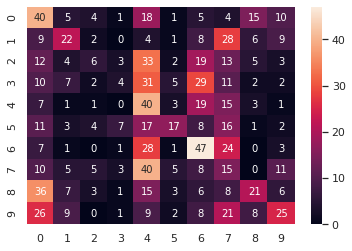

In [7]:
def plot_confusion_matrix(y, y_pred):
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y, y_pred))
    sns.set(font_scale=1.) # for label size
    sns.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 10}) # font size

def show_misclassified_example(x, y, y_pred):
    misclassified_mask = [y != y_pred]
    #print(y_misclassified)
    i = np.random.choice(x[misclassified_mask].shape[0])
    plt.imshow(x[misclassified_mask][i], cmap='gray')
    plt.show()
    print(f"y: {y[misclassified_mask][i]}\ny_pred: {y_pred[misclassified_mask][i]}")

y_test_pred = model.predict(x_test)
plot_confusion_matrix(y_test, np.argmax(y_test_pred, axis=1).astype('uint8'))


<ipython-input-7-fc9a6592ab6d>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  i = np.random.choice(x[misclassified_mask].shape[0])
<ipython-input-7-fc9a6592ab6d>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.imshow(x[misclassified_mask][i], cmap='gray')


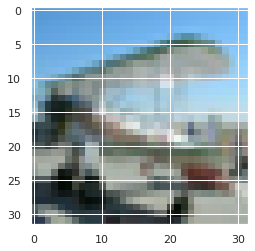

y: 0
y_pred: 8


<ipython-input-7-fc9a6592ab6d>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(f"y: {y[misclassified_mask][i]}\ny_pred: {y_pred[misclassified_mask][i]}")


In [38]:
show_misclassified_example(x_test, 
                           y_test.reshape(1000), 
                           np.argmax(y_test_pred, axis=1).astype('uint8') )